<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Working with reduced backends and noise models.

In this tutorial we will see how to target a sub-graph of a quantum device by reducing the coupling map from a device backend and performing noise simulations on this sub-graph by reducing the noise model for the backend.

In [10]:
from qiskit import *
from qiskit.compiler import transpile
from qiskit.transpiler.coupling import CouplingMap
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

### Load IBMQ accounts and grab target device backend

In [ ]:
IBMQ.load_accounts()

In [12]:
backend = IBMQ.get_backend('ibmq_16_melbourne')
print('Device has:', backend.configuration().n_qubits, 'qubits')

Device has: 14 qubits


### Problem setup

Suppose we have a quantum circuit that we want to run on a given quantum device that is smaller than the full size of the device, and which we want to map to a selected subset of qubits in the device layout.  As an example, lets consider the standard Bell state circuit:

In [14]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

qc.h(q[0])
qc.cx(q[0], q[1])
qc.measure(q, c);

that we wish to run on qubits 11 and 12 of the target device.  We will call these qubits the `target_qubits`:

In [15]:
target_qubits = [11, 12]

### Standard transpilation

Lets transpile the circuit for the given backend, making sure to map the circuit to the `target_qubits`:

In [16]:
new_qc = transpile(qc, backend, initial_layout=target_qubits)
new_qc.draw()

We can see that the circuit gets transformed so that the number of qubits in the circuit is equal to the number of qubits in the device, and the gates did indeed get mapped to the `target_qubits`.

The above example also highlights one of the downsides of transpiling circuits that are much smaller than the full size of the device; The transpiled circuit is padded with qubits that play no role in computation.  As such, it may be of interest to extract the sub-graph of the device defined by the `target_qubits` and use that in the transpilation process.

### Reducing the device coupling map

A reduced coupling map is a map that takes the sub-graph of a device defined by `target_qubits` and returns the same sub-graph coupling map, but with qubits labeled from 0->(N-1) where N is the number of qubits in `target_qubits`.  First we need to get the device coupling map and create a `CouplingMap` object from it.

In [18]:
cmap = backend.configuration().coupling_map
CMAP = CouplingMap(cmap)
print(CMAP)

[[1, 0], [1, 2], [2, 3], [4, 3], [4, 10], [5, 4], [5, 6], [5, 9], [6, 8], [9, 8], [9, 10], [7, 8], [11, 3], [11, 10], [11, 12], [12, 2], [13, 1], [13, 12]]


To reduce the coupling map defined by `target_qubits` we make use of the `CouplingMap.reduce()` method, and pass `target_qubits` to it.

In [19]:
red_cmap = CMAP.reduce(target_qubits)
print(red_cmap)

[[0, 1]]


We are returned a `CouplingMap` instance that shows the controlled-x gate connectivity between the `target_qubits` with the indices of the qubits reduced.  This can now be passed to the transpile function to generate a new circuit that has the same number of qubits as the original circuit.

In [20]:
red_qc = transpile(qc, None, coupling_map=red_cmap)

In [21]:
red_qc.draw()

### Executing a circuit transpiled with a reduced coupling map on a device

To `execute` a circuit compiled with a reduced layout on the actual device, one simply passes the `target_qubits` list as the `initial_layout`

In [37]:
job_device = execute(red_qc, backend, initial_layout=target_qubits)
job_monitor(job_device)

Job Status: job has successfully run


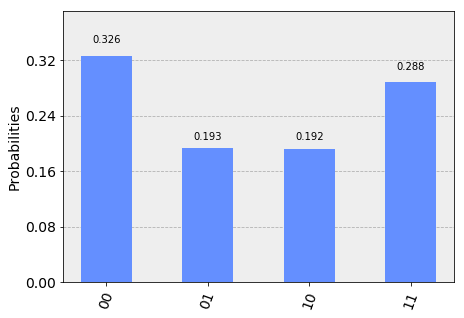

In [38]:
plot_histogram(job_device.result().get_counts())

### Noise modelling using reduced noise models

We have just seen how to take the `coupling_map` of a device, reduce a given sub-graph of that device, and use it in the transpiling process and then execution on the device.  We will now show how to do a noisy simulation using the reduced circuit and a noise model that is also reduced in size.  The combination of reduced coupling and noise maps allows us to easily simulate sub-graphs of large, e.g. >50 qubit, devices in the presence of noise.

First we need to import the noise library from the Aer provider

In [25]:
from qiskit.providers.aer import noise

Next we build a simplified noise model of the full device using data from the backend parameters:

In [26]:
properties = backend.properties()

In [36]:
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates
noise_model

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 3]), ('cx', [4, 3]), ('cx', [4, 10]), ('cx', [5, 4]), ('cx', [5, 6]), ('cx', [5, 9]), ('cx', [6, 8]), ('cx', [7, 8]), ('cx', [9, 8]), ('cx', [9, 10]), ('cx', [11, 3]), ('cx', [11, 10]), ('cx', [11, 12]), ('cx', [12, 2]), ('cx', [13, 1]), ('cx', [13, 12]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), 

Now we reduce the full noise model down using `remapping=target_qubits`, and `discard_qubits=True`.  This latter keyword argument trims the noise model down to just those noise terms that correspond to the reduced target qubits.

In [28]:
red_noise_model = noise.utils.remap_noise_model(noise_model,
                                                remapping=target_qubits,
                                                discard_qubits=True)
red_noise_model

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'measure', 'cx']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u3', [0]), ('u3', [1]), ('cx', [0, 1]), ('measure', [0]), ('measure', [1])]

### Verify reduced circuit and noise model give same results as full example

To show that the reduced and full noise models give the same answer we fix the random number generator in the simulator using the `seed_simulator` keyword argument.

In [31]:
sim_backend = Aer.get_backend('qasm_simulator')

#### Reduced model

In [32]:
job = execute(red_qc, sim_backend,
              basis_gates = basis_gates,
              noise_model=red_noise_model,
              seed_simulator=123456)
res = job.result()

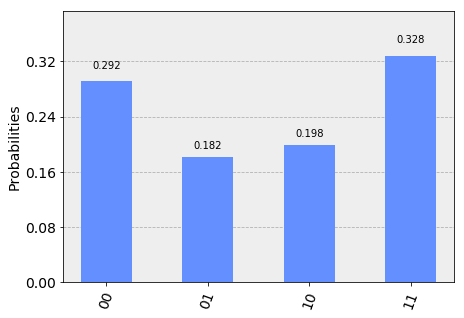

In [33]:
plot_histogram(res.get_counts())

#### Full model

In [34]:
job_full = execute(new_qc, sim_backend,
              basis_gates = basis_gates,
              noise_model=noise_model,
              seed_simulator=123456)
res_full = job_full.result()

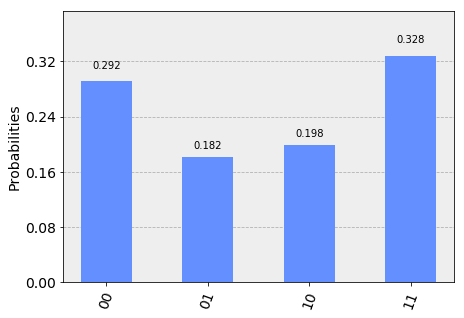

In [35]:
plot_histogram(res_full.get_counts())